In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

import logging

In [3]:
logging.getLogger().setLevel(logging.CRITICAL)

from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

In [4]:
jtplot.style('default', grid=False)
plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.5

plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [4]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

# Analysis experiments on Cu from september 2020

## Read processed experiments

In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/**/*.sxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if (' ' not in f) and ('/proc' in f) :
        files_new.append(f)
        
files = files_new
# files[0], files[1] = files[1], files[0]

files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20201019_5-Cu_FBI_subl_06min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20201019_5-Cu_FBI_subl_11min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20201019_5-Cu_FBI_subl_06min.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210119_7-Cu-FBI_subl_15min.sxy',
 '/Users/pabloherre

In [74]:
# colors = ['b', 'g', 'k', 'red', 'purple', 'brown']
proc_exps = [read_processed_xp(f) for f in files]
# for xp, c in zip(proc_exps, colors):
#     xp.color = c

## Show individual plots

In [75]:
regions = proc_exps[0].dfx.columns.levels[0].values
regions= ['N_1s', 'C_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

In [85]:
proc_exps[0].color, proc_exps[0].name

('k', '1-Cu_clean')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26eb4828>,
      dtype=object)

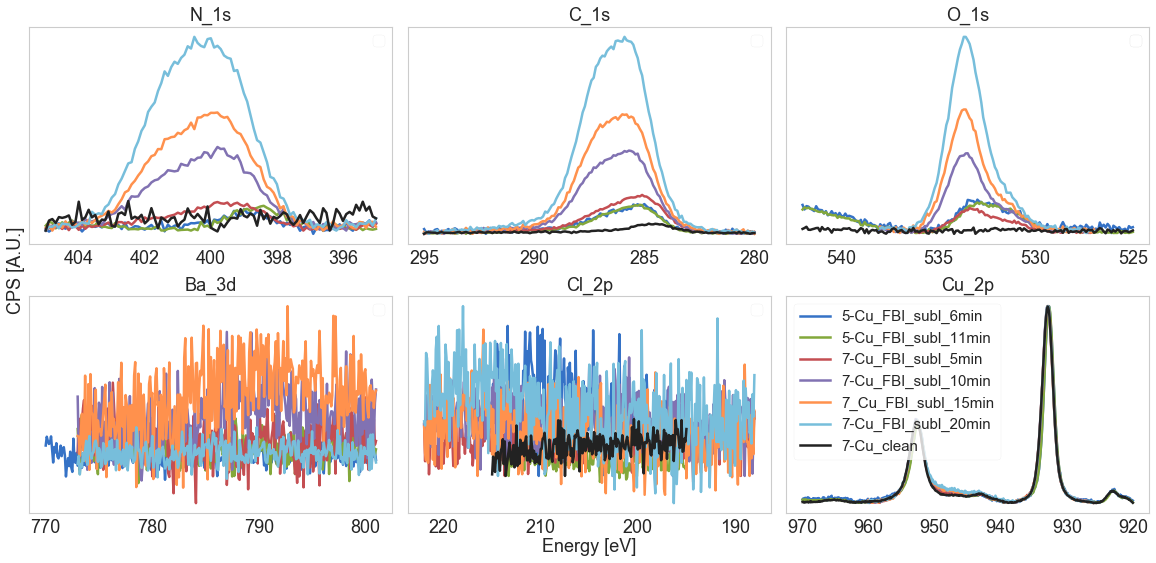

In [76]:
plot_xp_regions(proc_exps, regions, ncols=3)
# plt.gcf().set_size_inches(20,10)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/FBI_Ba_reproducibility2.png', dpi=200)

In [79]:
shift = find_shift(xp=proc_exps[0], xpRef=proc_exps[6], region='Cu_2p')

for xp in proc_exps[:2]:
    align_dfx(xp, shift, inplace=True)

### Normalized spectra

In [31]:
def plot_normal_regions(experiments : list, regions : list):
    """Subplots all normalized regions of a list of experiments"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for xp in experiments:
            xp_norm = normalise_dfx(xp, inplace=False)
            j, k = i//3, i%3
            if i == len(experiments):   # Set labels from last region
                plot_region(xp_norm, r, ax=ax[j][k], lb=xp_norm.name)
                ax[j][k].set_title('Au_4f')
            else:
                plot_region(xp_norm, r, ax=ax[j][k], lb='__nolabel__')
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(regions)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29a69d68>,
      dtype=object)

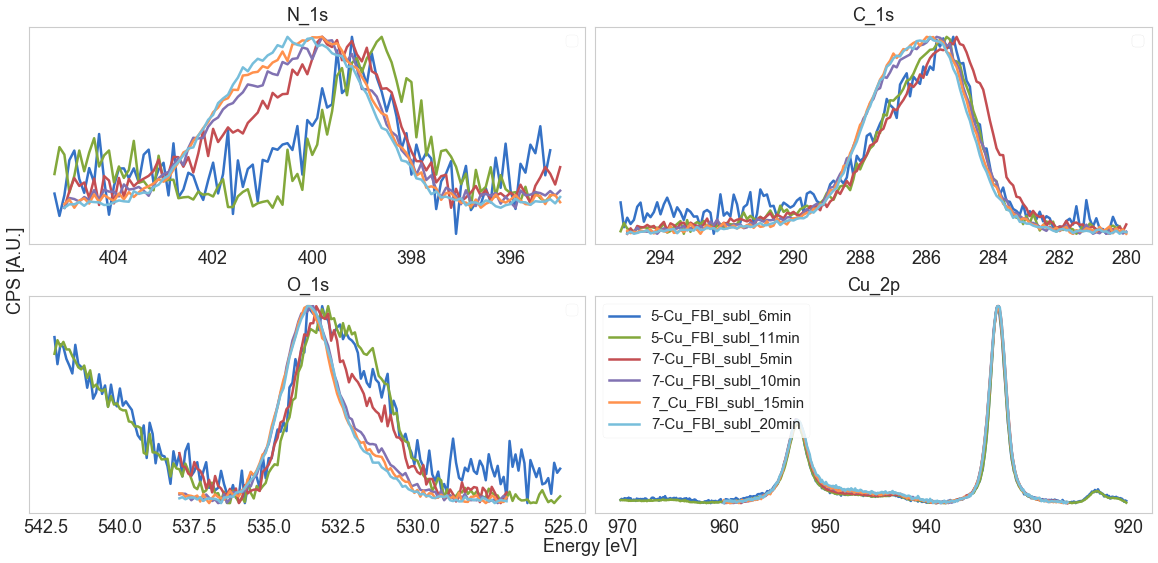

In [82]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Cu_2p']
plot_normal_regions(proc_exps[:6], regions, ncols=2)

## Integrate areas 

### C 1s

[1168.5838555360144,
 1045.0510602090421,
 1508.0408321497366,
 3274.2155587395478,
 4619.694151681803,
 7380.248785466943,
 381.03756002610527]

<Figure size 460.8x403.2 with 0 Axes>

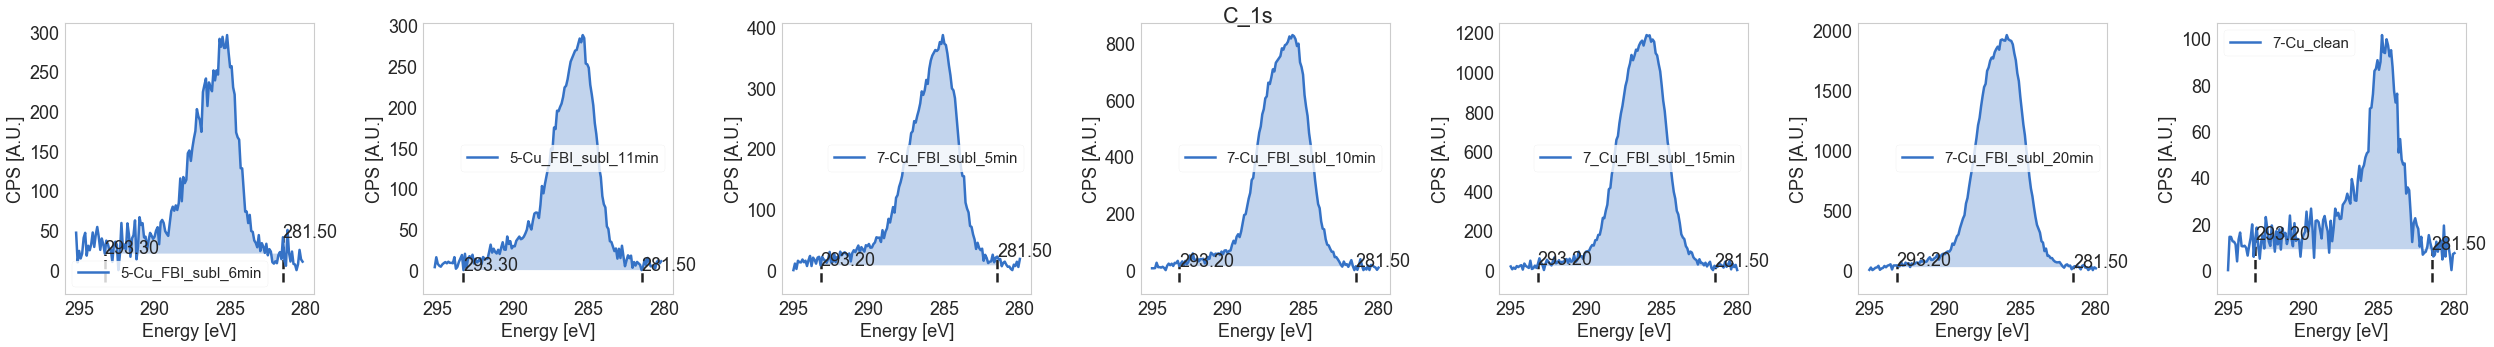

In [90]:
region = 'C_1s'
integrateRegions(proc_exps, region, indRef=1, asf=asf)

#### Correct for bg substrate abundance

In [91]:
for xp in proc_exps[:6]:
    uncorr_area = xp.area['C_1s']
    xp.area.update({'C_1s': uncorr_area - proc_exps[6].area['C_1s']})

### O 1s

[1014.0530636487262,
 849.96852218939,
 624.1212828860524,
 1766.53383493506,
 2620.3246970235273,
 4047.995671640308,
 176.00770001268808]

<Figure size 460.8x403.2 with 0 Axes>

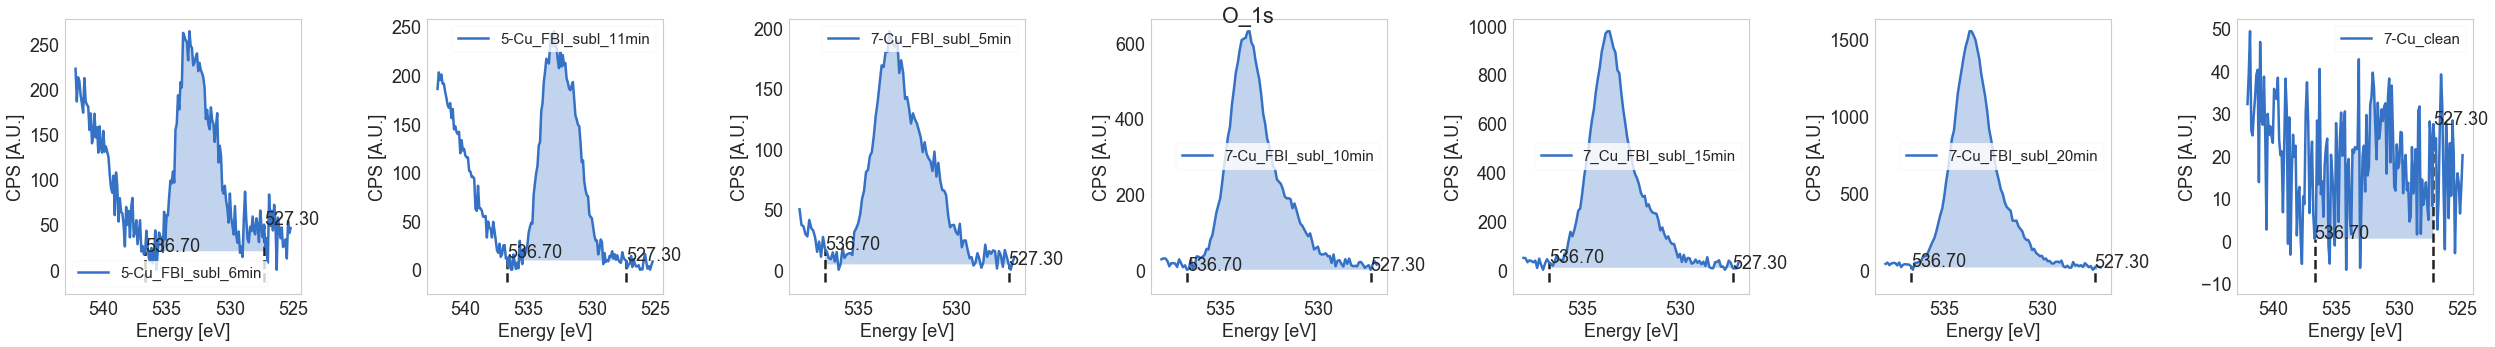

In [92]:
region = 'O_1s'
integrateRegions(proc_exps, region, indRef=3, asf=asf)

#### Correct for bg substrate abundance

In [93]:
for xp in proc_exps[:6]:
    uncorr_area = xp.area['O_1s']
    xp.area.update({'O_1s': uncorr_area - proc_exps[6].area['O_1s']})

### N 1s

[92.01345504998943,
 106.78973319979214,
 166.91531613876236,
 489.76148048271983,
 707.2229683634272,
 1137.3608694996215,
 168.58820918082222]

<Figure size 460.8x403.2 with 0 Axes>

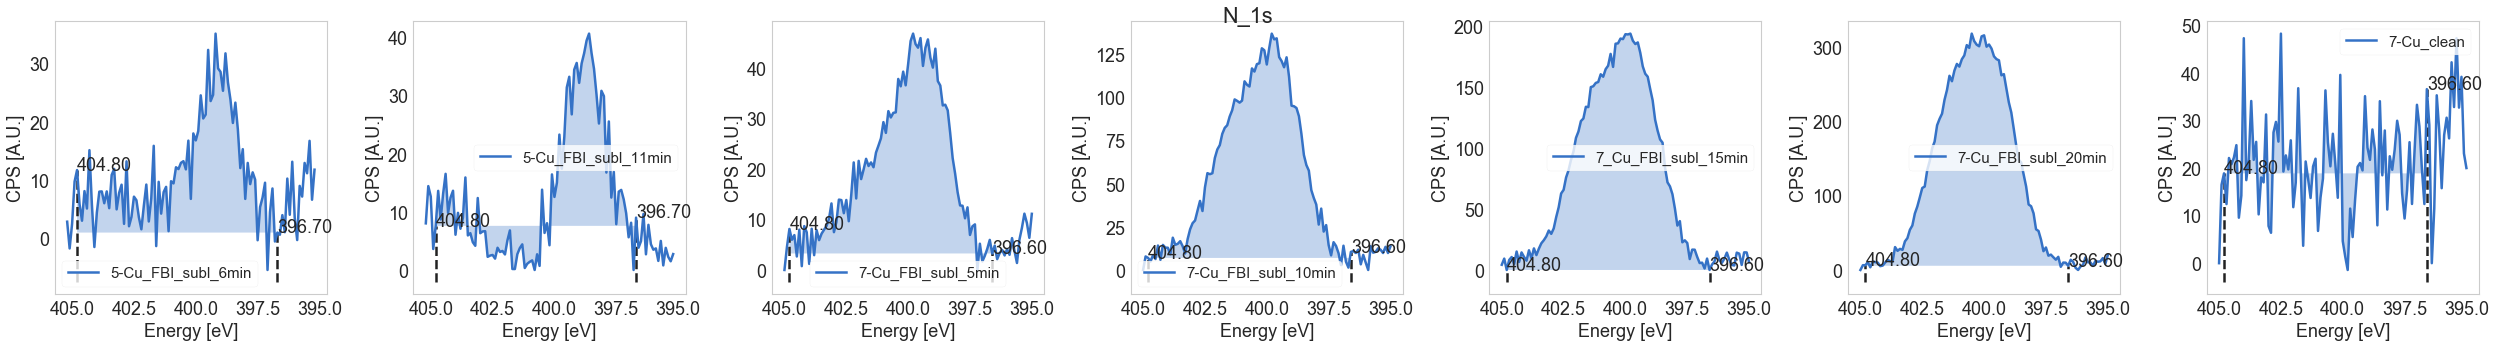

In [94]:
region = 'N_1s'
integrateRegions(proc_exps, region, indRef=4, asf=asf)

### Ba 3d

'Ba_3d' region does not exist in 5-Cu_FBI_subl_6min


[845.9747629118989,
 1465.410646544773,
 1843.4146719773184,
 4211.172921490679,
 5814.442688437241,
 1184.4734372887706]

<Figure size 460.8x403.2 with 0 Axes>

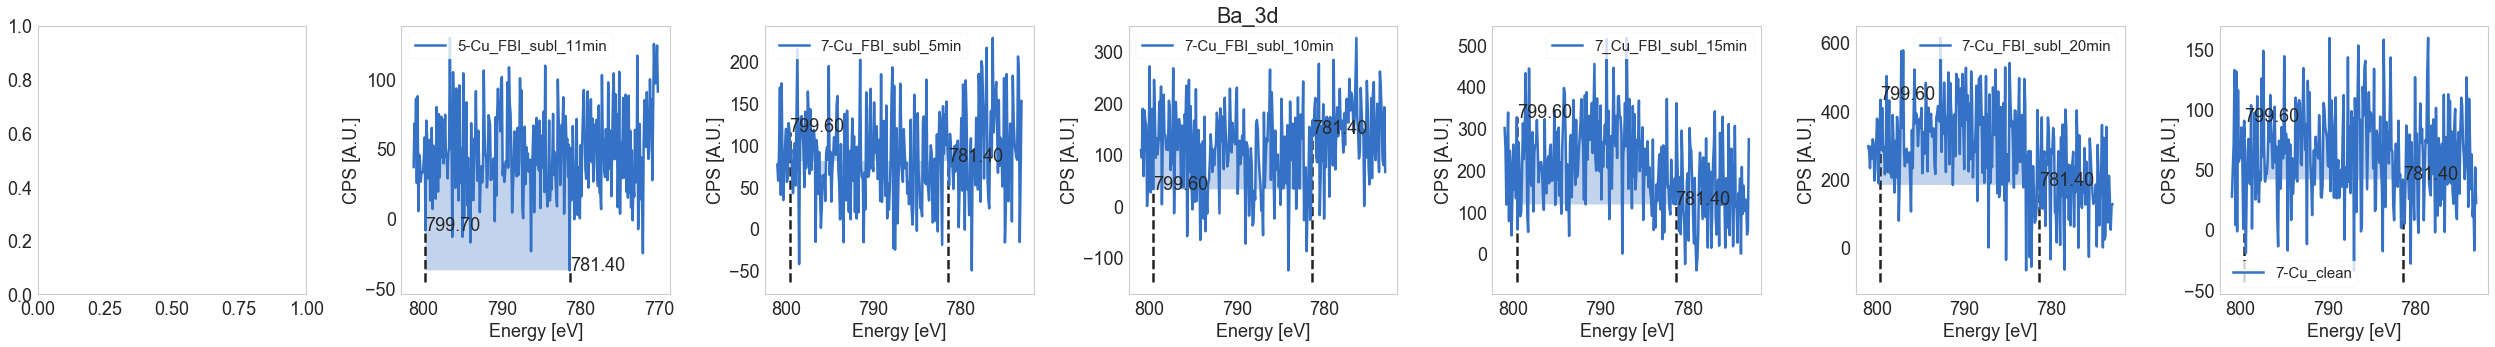

In [95]:
region = 'Ba_3d'
integrateRegions(proc_exps, region, indRef=1, asf=asf)

### Cl 2p

[515.8445135488869,
 127.31545002853795,
 588.0657172904766,
 837.8549719423067,
 554.9165550828179,
 857.1517192758556,
 304.47217397223346]

<Figure size 460.8x403.2 with 0 Axes>

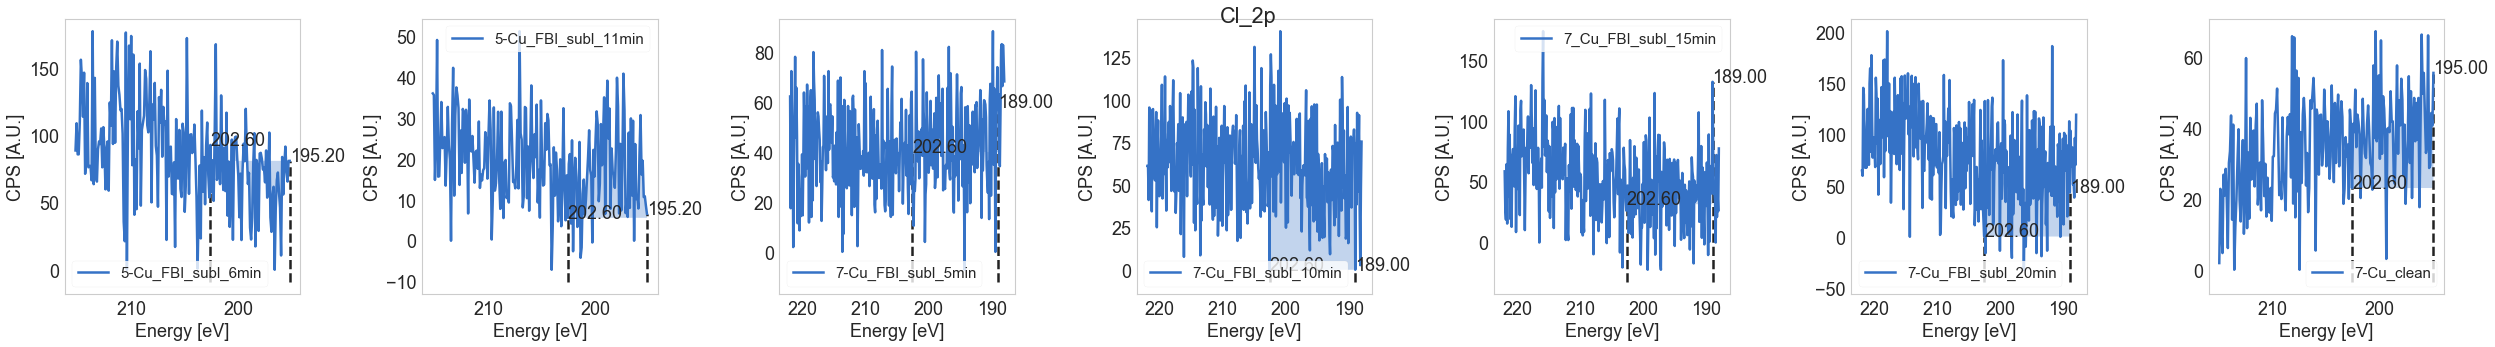

In [96]:
region = 'Cl_2p'
integrateRegions(proc_exps, region, indRef=3, asf=asf)

In [45]:
xp.area

{'C_1s': 11443.384606398304,
 'O_1s': 2799.3710450430726,
 'N_1s': 628.8227129376892,
 'Ba_3d': 753.164282744154,
 'Cl_2p': 1997.9874996013286}

### Cu 2p

[130231.23772033285,
 126932.17142218372,
 136587.32478060544,
 140756.83237655525,
 138949.1039343378,
 143744.3114384762,
 134912.41305129288]

<Figure size 460.8x403.2 with 0 Axes>

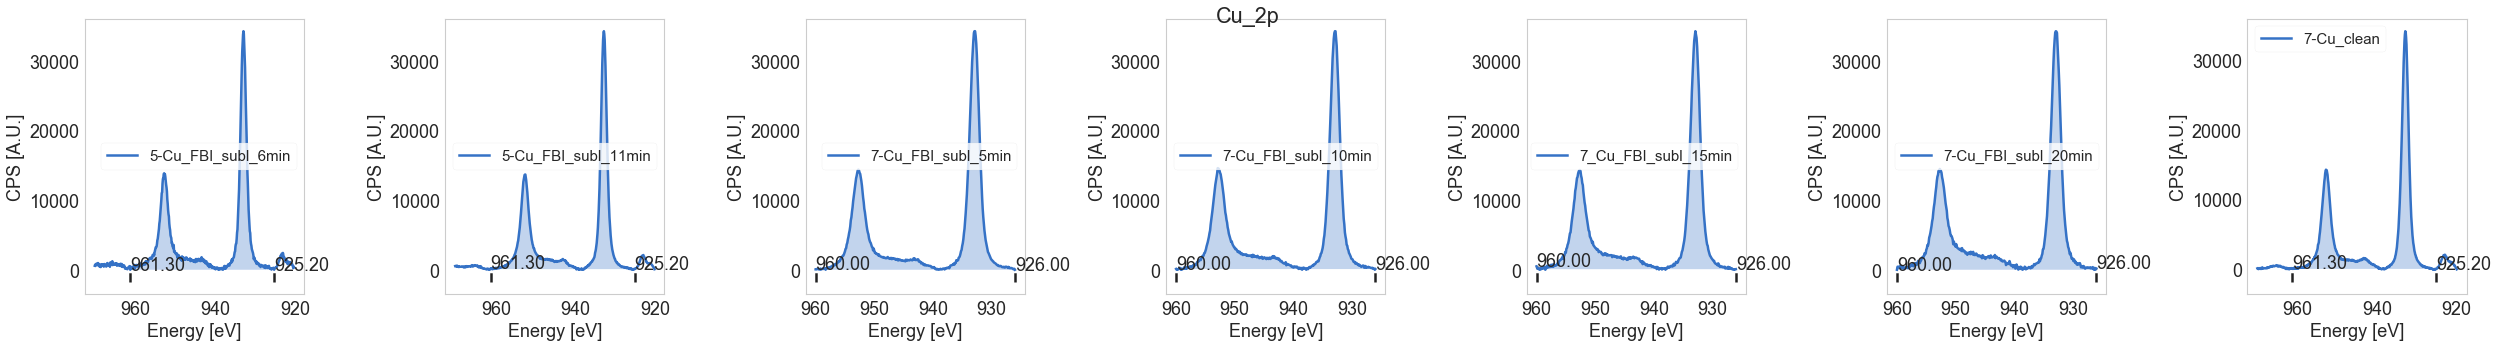

In [97]:
region = 'Cu_2p'
integrateRegions(proc_exps, region, indRef=0, asf=asf)

## Stoichiometry 

In [98]:
num, denom = (('N_1s', 'C_1s', 'C_1s'), ('O_1s', 'N_1s', 'O_1s',))
make_stoichometry_table(proc_exps,  num=num, denom=denom)
print('Nominal \t', 3/5, '\t', '%.3f'%(31/3), '\t', '%.3f' %(31/5))

Experiment	N_/O_	C_/N_	C_/O_	
5-Cu_FBI_subl_6min	0.16 	 13.79 	 2.26 	 
5-Cu_FBI_subl_11min	0.24 	 10.02 	 2.37 	 
7-Cu_FBI_subl_5min	0.56 	 10.88 	 6.04 	 
7-Cu_FBI_subl_10min	0.46 	 9.52 	 4.37 	 
7_Cu_FBI_subl_15min	0.43 	 9.66 	 4.17 	 
7-Cu_FBI_subl_20min	0.44 	 9.92 	 4.34 	 
7-Cu_clean	1.43 	 3.64 	 5.20 	 
Nominal 	 0.6 	 10.333 	 6.200


## Coverage

### Read unscaled experiments

In [5]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if (' ' not in f) and ('/proc' in f) :
        files_new.append(f)
        
files = files_new[2:] # Exclude the 2 experiments from 19th November 2020 (comparison only)

files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy']

In [6]:
bg_exps = [read_processed_xp(f) for f in files]

In [7]:
from invisible_cities.core.system_of_units import nm
thickness = []
for xp in bg_exps[:4]:
    thick = layer_thickness(xpf=xp, xp0=bg_exps[4], region='Cu_2p', mfp=2.75*nm, takeoff = 10)
    print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
    

0.947 ± 0.005
1.822 ± 0.005
2.369 ± 0.006
3.063 ± 0.006


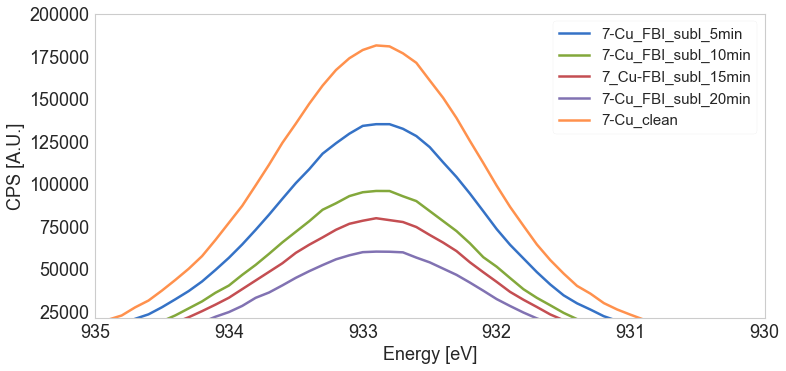

In [8]:
for xp in bg_exps:
    plot_region(xp, 'Cu_2p')
plt.gca().set(ylim=(2.1e4, 2.0e5), xlim=(935,930))
plt.gcf().set_figwidth(12)

### Previous progressive growth test (19th October 2020)

In [120]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if (' ' not in f) and ('/proc' in f) :
        files_new.append(f)
        
files = files_new
files[2], files[0] = files[0], files[2]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201019_5-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201019_5-Cu_FBI_subl_6min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201019_5-Cu_FBI_subl_11min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201020_5-Cu_FBI_subl_16min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201020_5-Cu_FBI_subl_21min.uxy']

In [121]:
bg_exps2 = [read_processed_xp(f) for f in files]

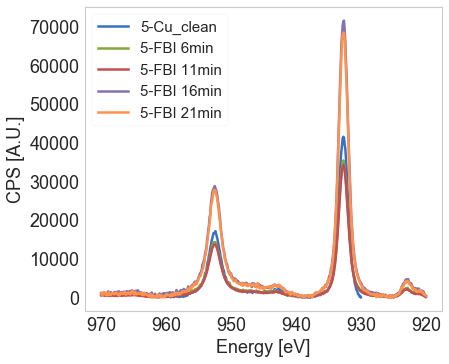

In [123]:
for xp in bg_exps2:
    plot_region(xp, 'Cu_2p')

In [124]:
scaled_exps = bg_exps2
scale_dfx(scaled_exps[3], scale_factor=0.46, inplace=True)
scale_dfx(scaled_exps[4], scale_factor=0.46, inplace=True);

XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2020_10_19_Cu/proc/2020_10_19_Cu20201020_5-Cu_FBI_subl_21min.uxy', delimiters="([42, 1275, 1454, 1583, 1812, 2011, 2540], [1205, 151, 101, 201, 171, 501, 311], ['overview_', 'C_1s', 'N_1s', 'Cl_2p', 'O_1s', 'Cu_2p', 'Ba_3d'])", name='5-FBI 21min', label='20201020_5-Cu_FBI_subl_21min', date='2020.10.20', other_meta='5-Cu_FBI_subl_21min', dfx=      Ba_3d             C_1s             Cl_2p             Cu_2p          \
     energy    counts energy     counts energy     counts energy  counts   
0     801.0  0.002551  295.0  16.437318  215.0   4.642752  970.0  480.24   
1     800.9  0.001761  294.9  11.408000  214.9   6.728626  969.9  257.60   
2     800.8  0.003306  294.8   7.421318  214.8   3.095168  969.8  259.44   
3     800.7  0.002694  294.7   2.392000  214.7   9.083645  969.7  460.92   
4     800.6  0.001047  294.6  13.493318  214.6  10.160225  969.6  580.52   
5     800.5  0.002602  294.5  13.186636  214.5   5

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:67: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


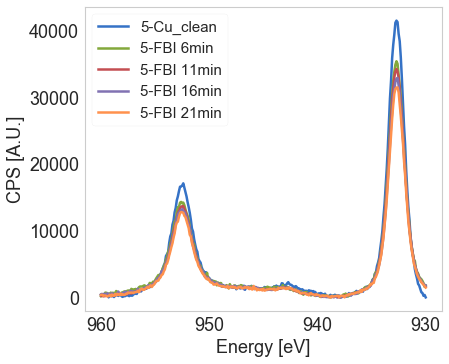

In [129]:
for xp in scaled_exps:
    crop_spectrum(xp, region='Cu_2p', eup=960, edw=930, inplace=True)
    plot_region(xp, 'Cu_2p')
    

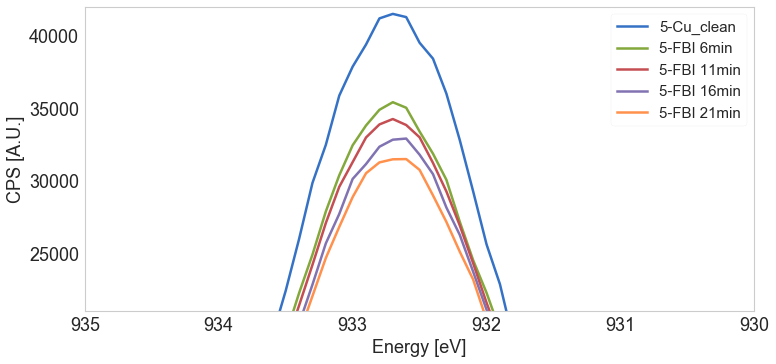

In [134]:
for xp in scaled_exps:
    plot_region(xp, 'Cu_2p')
plt.gca().set(ylim=(2.1e4, 4.2e4), xlim=(935,930))
plt.gcf().set_figwidth(12)

In [135]:
from invisible_cities.core.system_of_units import nm
thickness = []
for xp in bg_exps2[1:]:
    thick = layer_thickness(xpf=xp, xp0=bg_exps2[0], region='Cu_2p', mfp=3.75*nm, takeoff = 10)
    print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
    

0.369 ± 0.015
0.574 ± 0.015
0.641 ± 0.015
0.819 ± 0.015


### Compare LA to MA

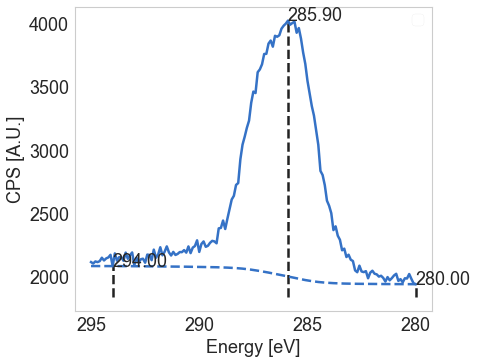

In [149]:
region = 'C_1s_MA'
bg_exps[3] = subtract_shirley_bg(bg_exps[3], region)

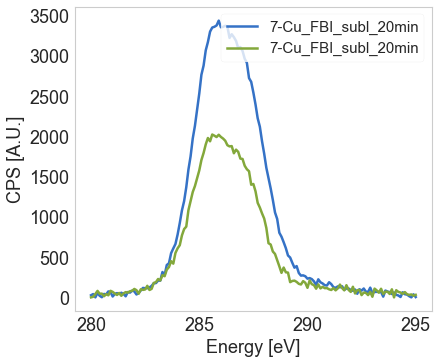

In [150]:
plot_region(bg_exps[3], 'C_1s')
plot_region(bg_exps[3], 'C_1s_MA')


In [152]:
cla = bg_exps[3].dfx['C_1s'].dropna().counts
cma = bg_exps[3].dfx[region].dropna().counts
np.trapz(cla, dx=0.1) / np.trapz(cma, dx=0.1)

1.6486848581139746

In [153]:
0.947/0.369

2.5663956639566394

### Coverage 2.5 min to 60 min: PLOT coverage vs evap time

In [17]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if (' ' not in f) and ('/proc' in f) :
        files_new.append(f)
files = files_new

files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210121_8-Cu_FBI_subl_05min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_8-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_8-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_9-Cu_FBI_subl_2p5min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_9-Cu_clean.uxy']

In [18]:
bg_exps = [read_processed_xp(f) for f in files]

In [19]:
from invisible_cities.core.system_of_units import nm
thickness = []
for xp in bg_exps[:8]:
    thick = layer_thickness(xpf=xp, xp0=bg_exps[8], region='Cu_2p', mfp=3.45*nm, takeoff = 10)
    thickness.append(thick)
    print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
thickm = np.matrix(thickness)

0.947 ± 0.006
2.045 ± 0.007
2.732 ± 0.007
3.602 ± 0.008
1.110 ± 0.006
3.011 ± 0.008
6.116 ± 0.011
0.825 ± 0.006


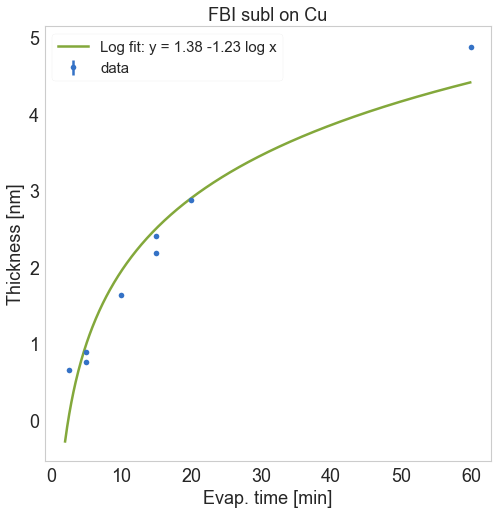

In [12]:
plt.figure(figsize=(8,8))
tsubl = [5, 10, 15, 20, 5, 15, 60, 2.5]
plt.errorbar(x=tsubl, y=thickm[:,0]/nm, yerr=thickm[:,1]/nm, fmt='o', label='data')
fit = np.polyfit(np.log(tsubl), thickm[:,0], 1)

xvals = np.arange(2, 60, 0.1)
fitvals = np.polyval(fit, np.log(xvals)) / nm
plt.plot(xvals, fitvals, '-', label='Log fit: y = %.2f %.2f log x' %(fit[0]/nm, fit[1]/nm)) 

plt.ylabel('Thickness [nm]')
plt.xlabel('Evap. time [min]')
plt.title('FBI subl on Cu')
plt.legend()

#### Exclude repeated 5 and 15 min

In [73]:
bg_exps.pop(4)
bg_exps.pop(4);

XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_8-Cu_FBI_subl_15min.uxy', delimiters="([42, 181, 360, 489, 1722, 2091, 2460], [111, 151, 101, 1205, 341, 341, 281], ['O_1s', 'C_1s', 'N_1s', 'overview_', 'Cu_2p', 'Cl_2p', 'Ba_3d'])", name='8-Cu_FBI_subl_15min', label='20210122_8-Cu_FBI_subl_15min', date='20.21.0122', other_meta='8-Cu_FBI_subl_15min', dfx=range        O_1s               C_1s               N_1s              \
properties energy      counts energy      counts energy      counts   
0           538.0   59.750000  295.0   41.875000  405.0   31.575000   
1           537.9   70.000000  294.9    8.250000  404.9   20.750000   
2           537.8   40.625000  294.8    0.000000  404.8   31.325000   
3           537.7   40.875000  294.7   43.545833  404.7    0.000000   
4           537.6   31.875000  294.6   45.264308  404.6   24.995325   
5           537.5   37.500000  294.5   64.379711  404.5   19.013161   
6           537.4   18

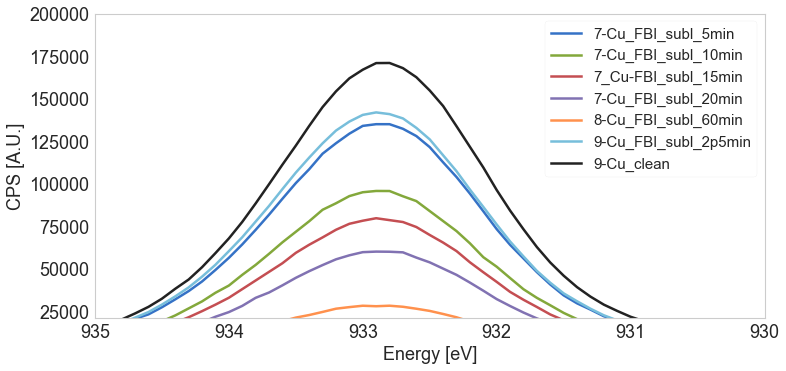

In [74]:
for xp in bg_exps:
    plot_region(xp, 'Cu_2p')
plt.gca().set(ylim=(2.1e4, 2.0e5), xlim=(935,930))
plt.gcf().set_figwidth(12)

XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_22_Cu/proc/20210122_9-Cu_FBI_subl_2p5min.uxy', delimiters="([42, 181, 360, 489, 1722, 2091, 2460, 2769, 2988], [111, 151, 101, 1205, 341, 341, 281, 191, 311], ['O_1s', 'C_1s', 'N_1s', 'overview_', 'Cu_2p', 'Cl_2p', 'Ba_3d', 'Ba_4d', 'N1s'])", name='9-Cu_FBI_subl_2p5min', label='20210122_9-Cu_FBI_subl_2p5min', date='20.21.0122', other_meta='9-Cu_FBI_subl_2p5min', dfx=range        O_1s              C_1s              N_1s             \
properties energy     counts energy     counts energy     counts   
0           538.0   6.292536  295.0   5.550000  405.0   5.974500   
1           537.9  18.223425  294.9   3.112500  404.9   8.933700   
2           537.8  12.429307  294.8   8.062500  404.8   7.683700   
3           537.7  -0.064842  294.7  10.300000  404.7  11.260300   
4           537.6   1.753442  294.6   9.275000  404.6  12.056200   
5           537.5  18.159127  294.5  19.287500  404.5   9.969400   
6   

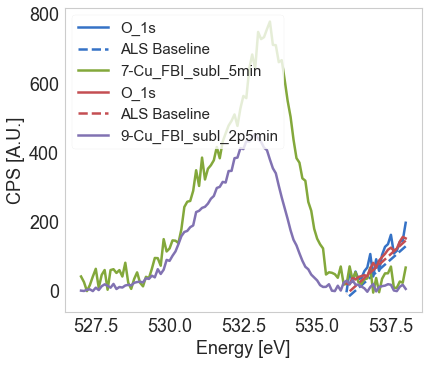

In [77]:
fix_tail_bg(bg_exps[0], region='O_1s', edw=536, inplace=True)
fix_tail_bg(bg_exps[5], region='O_1s', edw=536, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a13144128>,
      dtype=object)

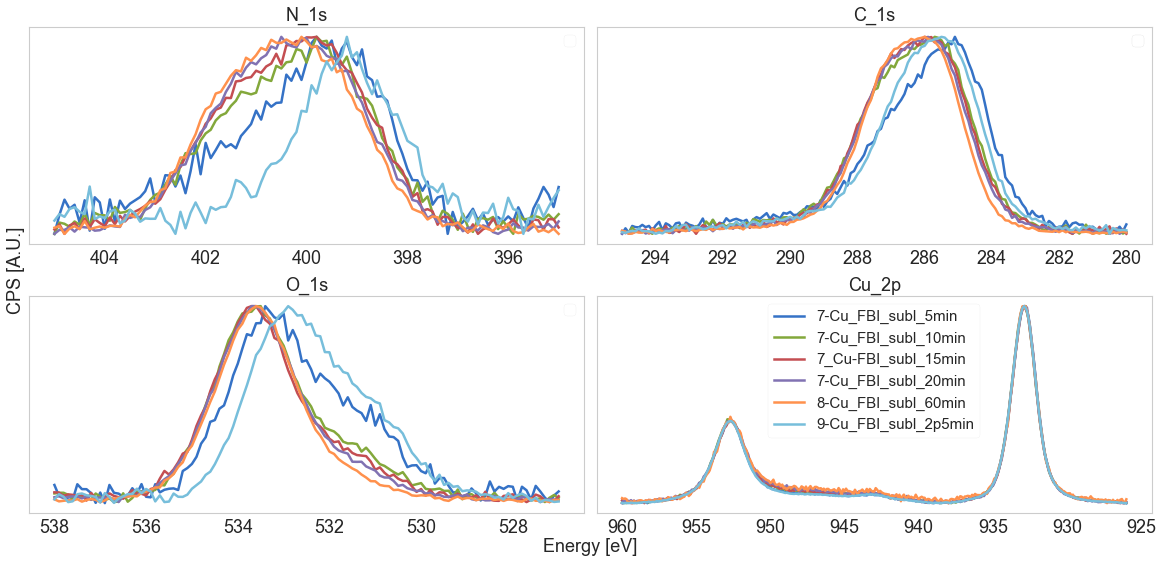

In [78]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Cu_2p']
plot_normal_regions(bg_exps[:6], regions, ncols=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15dba8d0>,
      dtype=object)

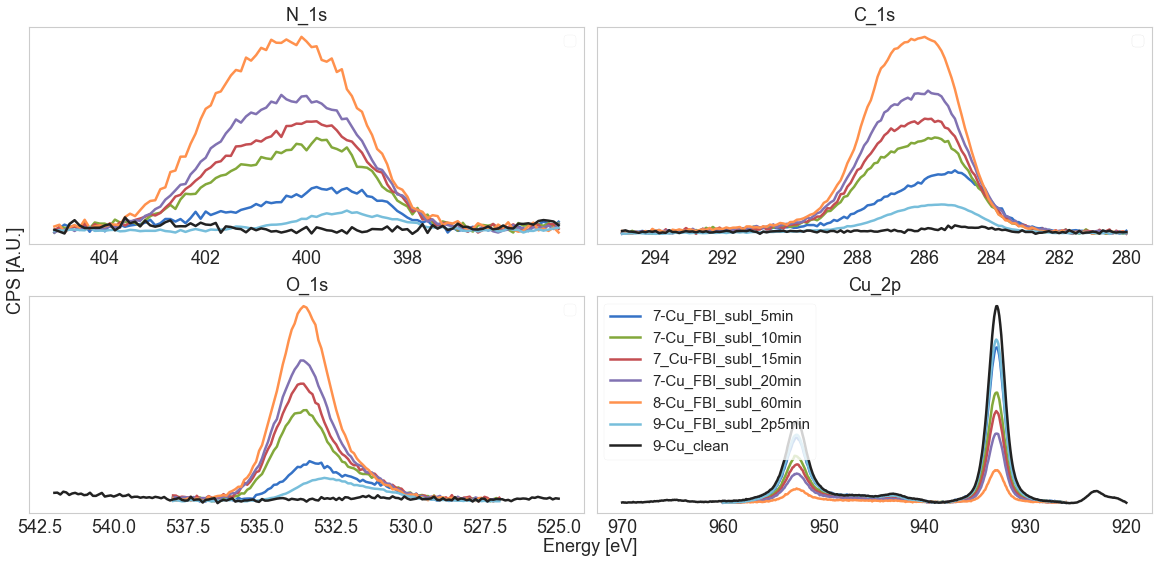

In [80]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Cu_2p']
plot_xp_regions(bg_exps, regions, ncols=2)

### At rate R1 ≈ R0/4

In [82]:
fileR1 = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu/proc/20210125_10-Cu_FBI_subl_10min.uxy'
bg_exps.append(read_processed_xp(fileR1))

In [85]:
thick = layer_thickness(xpf=bg_exps[7], xp0=bg_exps[6], region='Cu_2p', mfp=2.75*nm, takeoff = 10)
thickness.append(thick)
print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
thickm = np.matrix(thickness)

0.616 ± 0.005


In [96]:
thick

(6.164286369776117e-07, 4.982544001342605e-09)

In [100]:
thick/thickm[1]

matrix([[0.37817255, 0.89699425]])

In [90]:
thickm = np.matrix(thickness)

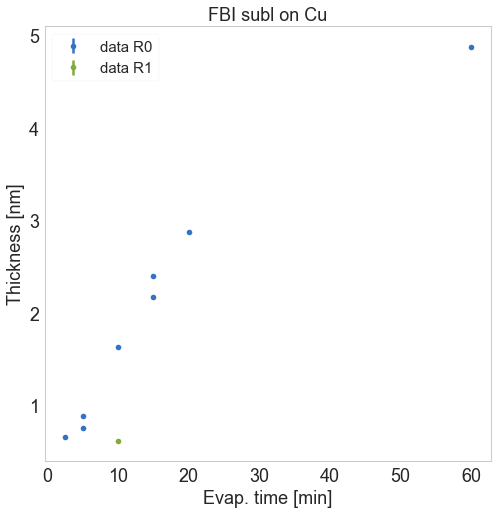

In [101]:
plt.figure(figsize=(8,8))
tsubl = [5, 10, 15, 20, 5, 15, 60, 2.5]
plt.errorbar(x=tsubl, y=thickm[:,0]/nm, yerr=thickm[:,1]/nm, fmt='o', label='data R0')
plt.errorbar(10, y=thick[0]/nm, yerr=thick[1]/nm, fmt='go', label='data R1')

fit = np.polyfit(np.log(tsubl), thickm[:,0], 1)
xvals = np.arange(2, 60, 0.1)
fitvals = np.polyval(fit, np.log(xvals)) / nm
# plt.plot(xvals, fitvals, '-', label='Log fit: y = %.2f %.2f log x' %(fit[0]/nm, fit[1]/nm)) 

plt.ylabel('Thickness [nm]')
plt.xlabel('Evap. time [min]')
plt.title('FBI subl on Cu')
plt.legend()

## Rate calibration

In [20]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []

for f in files:
    if (' ' not in f) and ('/proc' in f) :
        files_new.append(f)
files = files_new

files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10a-Cu_FBI_subl_10min_1p9V.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10a-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10b-Cu_FBI_subl_10min_1p95V.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10b-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10c-Cu_FBI_subl_10min_2V.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_25_Cu_rate_calibration/proc/20210125_10c-Cu_clean.uxy']

In [21]:
bg_expsR = [read_processed_xp(f) for f in files]

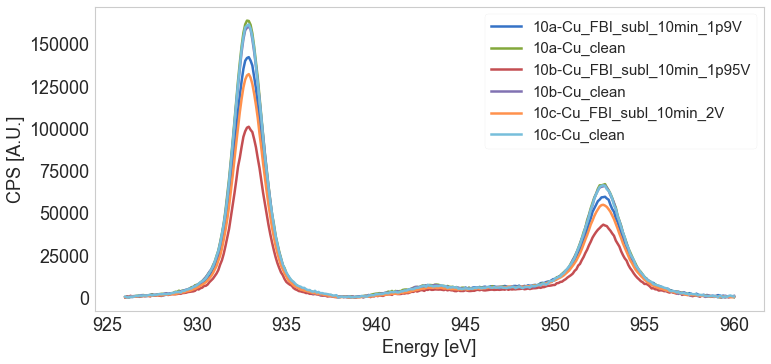

In [27]:
for xp in bg_expsR:
    plot_region(xp, 'Cu_2p')
# plt.gca().set(ylim=(2.1e4, 2.0e5), xlim=(935,930))
plt.gcf().set_figwidth(12)

In [26]:
from invisible_cities.core.system_of_units import nm
thicknessR = []

thick = layer_thickness(xpf=bg_expsR[0], xp0=bg_expsR[1], region='Cu_2p', mfp=3.45*nm, takeoff = 10)
print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))

thick = layer_thickness(xpf=bg_expsR[2], xp0=bg_expsR[3], region='Cu_2p', mfp=3.45*nm, takeoff = 10)
print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))

thick = layer_thickness(xpf=bg_expsR[4], xp0=bg_expsR[1], region='Cu_2p', mfp=3.45*nm, takeoff = 10)
# thicknessR.append(thick)
print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
# thickm = np.matrix(thicknessR)

0.399 ± 0.006
1.500 ± 0.007
0.626 ± 0.007


In [16]:
thickm

matrix([[7.54945993e-07, 5.05236613e-09],
        [1.63001952e-06, 5.55471119e-09],
        [2.17731418e-06, 5.92817657e-09],
        [2.87105071e-06, 6.47599275e-09],
        [8.84789307e-07, 5.12010820e-09],
        [2.39976568e-06, 6.09436358e-09],
        [4.87491310e-06, 8.62313140e-09],
        [6.57943274e-07, 5.00320917e-09]])

In [85]:
thick = layer_thickness(xpf=bg_exps[7], xp0=bg_exps[6], region='Cu_2p', mfp=2.75*nm, takeoff = 10)
thickness.append(thick)
print('%.3f ± %.3f' %(thick[0]/nm, thick[1]/nm))
thickm = np.matrix(thickness)

0.616 ± 0.005


In [96]:
thick

(6.164286369776117e-07, 4.982544001342605e-09)

In [100]:
thick/thickm[1]

matrix([[0.37817255, 0.89699425]])

In [90]:
thickm = np.matrix(thickness)

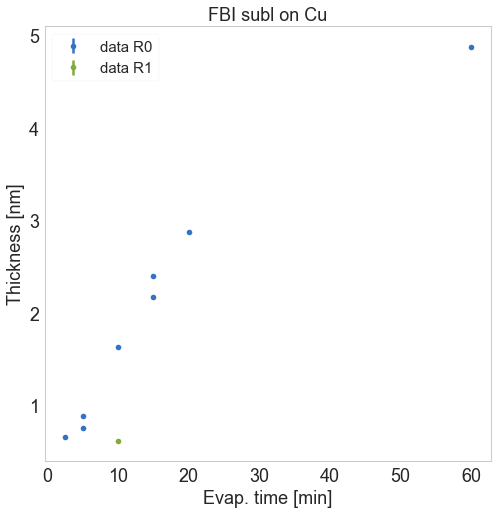

In [101]:
plt.figure(figsize=(8,8))
tsubl = [5, 10, 15, 20, 5, 15, 60, 2.5]
plt.errorbar(x=tsubl, y=thickm[:,0]/nm, yerr=thickm[:,1]/nm, fmt='o', label='data R0')
plt.errorbar(10, y=thick[0]/nm, yerr=thick[1]/nm, fmt='go', label='data R1')

fit = np.polyfit(np.log(tsubl), thickm[:,0], 1)
xvals = np.arange(2, 60, 0.1)
fitvals = np.polyval(fit, np.log(xvals)) / nm
# plt.plot(xvals, fitvals, '-', label='Log fit: y = %.2f %.2f log x' %(fit[0]/nm, fit[1]/nm)) 

plt.ylabel('Thickness [nm]')
plt.xlabel('Evap. time [min]')
plt.title('FBI subl on Cu')
plt.legend()